In [1]:
import Bio as bp 
import pysam
import h5py
import pandas as pd
import numpy as np
import seaborn as sns 
import scipy
import matplotlib.pyplot as plt

In [2]:
# function to extract info from Tapestri H5 files
def extract_tapestri(tapestri_file):
    '''
    INPUT: A Tapestri CNV + SNV file in HD5 format
    OUTPUT:
        1. cells: Dataframe of information about all selected cells
        2. amplicons: Dataframe of information for targeted amplicons
        3. read_counts: Dataframe of sequencing read counts per cell barcode (index) and amplicon (columns)
        4: variants: Dataframe of information for inferred SNVs
        5. vafs : Dataframe of variant allele frequencies per cell barcode (index) and SNV (columns)
        6. covs : Dataframe of total sequencing coverage per cell barcode (index) and SNV (columns)
        7. filtermask: Dataframe of filtered masks per cell barcode (index) and SNV (columns)
        8. gqs: Dataframe of VCF-score GQS per cell barcode (index) and SNV (columns)
        9. ngts: Dataframe of VCF-score NGTS per cell barcode (index) and SNV (columns)
        10. rgqs: Dataframe of VCF-score RGQS per cell barcode (index) and SNV (columns)
        11: cell_filters: Dataframe of filtered cells
    '''
    with h5py.File(tapestri_file, "r") as f:
        read_counts = pd.DataFrame(data=f['assays']['dna_read_counts']['layers']['read_counts'][:],
                                index=f['assays']['dna_read_counts']['ra']['barcode'][:],
                                columns=f['assays']['dna_read_counts']['ca']['id'][:])
        cells = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_read_counts']['ra'].items()})
        amplicons = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_read_counts']['ca'].items()})
    with h5py.File(tapestri_file, "r") as f:
        variants = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_variants']['ca'].items()})
        vafs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['AF'][:] / 100.0,
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        covs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['DP'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        filtermask = pd.DataFrame(data=f['assays']['dna_variants']['layers']['FILTER_MASK'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        gqs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['GQ'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        ngts = pd.DataFrame(data=f['assays']['dna_variants']['layers']['NGT'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        rgqs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['RGQ'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        cell_filters = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_variants']['ra'].items()})
    return cells, amplicons, read_counts, variants, vafs, covs, filtermask, gqs, ngts, rgqs, cell_filters

In [3]:
cells, amplicons, read_counts, variants, vafs, covs, filtermask, gqs, ngts, rgqs, cell_filters = extract_tapestri("./data/4-cell-lines-AML-CNV.dna.h5")

# Single cell sequencing simulation

### Panel reference genome creation

- <font color='green'>dowload human reference genome, called ref_human_genome.fa </font>

### Get info of the panel (id , chromosome, position)

In [4]:
amplicon_search = amplicons[['id','CHROM','start_pos','end_pos']].copy()
amplicon_search.CHROM = amplicon_search.CHROM.apply(lambda x : 'chr'+str(int(x)))
amplicon_search.id = amplicon_search.id.apply(str)
amplicon_search

,id,CHROM,start_pos,end_pos
0,b'AML_v2_NRAS_115256512',chr1,115256488,115256723
1,b'AML_v2_NRAS_115258635',chr1,115258610,115258825
2,b'AML_v2_DNMT3A_25457166',chr2,25457144,25457372
3,b'AML_v2_DNMT3A_25458540',chr2,25458519,25458763
4,b'AML_v2_DNMT3A_25459813',chr2,25459794,25460046
...,...,...,...,...
122,b'AML_v2_RUNX1_36206703',chr21,36206684,36206913
123,b'AML_v2_RUNX1_36231714',chr21,36231693,36231937
124,b'AML_v2_RUNX1_36252844',chr21,36252820,36253046
125,b'AML_v2_U2AF1_44514570',chr21,44514550,44514808


#### reformat for small experiment

In [5]:
all_start = [np.random.randint(low=1,high=2200) for _ in range(127)] 
while np.unique(all_start).shape[0] < 127:
    all_start = [np.random.randint(low=1,high=2200) for _ in range(127)] 
    all_end = [s + 200 for s in all_start ]
np.unique(all_start).shape

(127,)

In [6]:
amplicon_search['start_pos'] = all_start
amplicon_search['end_pos'] = all_end

### final dataframe

In [7]:
amplicon_search

,id,CHROM,start_pos,end_pos
0,b'AML_v2_NRAS_115256512',chr1,52,252
1,b'AML_v2_NRAS_115258635',chr1,1936,2136
2,b'AML_v2_DNMT3A_25457166',chr2,1589,1789
3,b'AML_v2_DNMT3A_25458540',chr2,1800,2000
4,b'AML_v2_DNMT3A_25459813',chr2,2083,2283
...,...,...,...,...
122,b'AML_v2_RUNX1_36206703',chr21,231,431
123,b'AML_v2_RUNX1_36231714',chr21,450,650
124,b'AML_v2_RUNX1_36252844',chr21,2132,2332
125,b'AML_v2_U2AF1_44514570',chr21,2059,2259


In [8]:
# cut the reference genome to recover amplicon sequence

from Bio import SeqIO
from Bio.SeqUtils import gc_fraction 

file = open("./genomes/panel_genome.fa", "w") # ref human genome
GC_content = {}

for seq_record in SeqIO.parse("./genomes/ref_genome.fa", "fasta"): # loop over chr 
    print(seq_record.id) # chr name 
    #print(repr(seq_record.seq)) # sequence 
    print(len(seq_record)) # length
    
    amplicon_in_seqrecord = amplicon_search[amplicon_search.CHROM == seq_record.id]
    if amplicon_in_seqrecord.size != 0: # some amplicon in chr : test
        for id, row in amplicon_in_seqrecord.iterrows(): #loop over amplicon in chr 
            id,chrom,start,end = row
            file.write(">"+ str(id)+"\n") # write id of amplicon
            amplicon_seq = seq_record.seq[start:end+1] # +1 because last excluded, get amplicon sequence
            file.write(str(amplicon_seq)+"\n")
            GC_content[id] = gc_fraction(amplicon_seq) 
file.close()

chr1
2346
chr2
2346


- gc_fraction(seq) : gives GC fraction for a seq

- art_illumina -ss HS25 -na -i panel_genome.fa -p -l 100 -f 50 -m 101 -s 1 -o paired_seq
( -ss sequencing system, -l r1/r2 length, -m fragment size)
- bwa index panel_genome.fa
- bwa mem panel_genome.fa paired_seq1.fq paired_seq2.fq | samtools sort -Obam -o align_seq.sorted.bam (alignment)
- samtools index align_seq.sorted.bam

<font color='green'>For art illumina should I simulate from panel_genome or panel_genome modified with detected SNV ? </font>

# Analysis

<font color='green'>Normalization with total generated reads or mapped ? </font>

In [9]:
samfile = pysam.AlignmentFile("./genomes/align_seq.sorted.bam", "rb") # open alignment sorted file
read_counts_info = {}
nb_mapped_reads = samfile.mapped #number of mapped read
for id in samfile.references:
    read_counts_info[id] = []
    read_counts_info[id].append(samfile.count(region= id)) #total nb of overlapping reads
    read_counts_info[id].append(read_counts_info[id][-1]/nb_mapped_reads) # proportion of overlapping reads
    read_counts_info[id].append(GC_content[id]) #gc fraction
    
    #print(len([r for r in samfile.fetch(region= id)]), samfile.count(region= id), samfile.count_coverage(contig=id ))

In [10]:
read_counts_info

{"b'AML_v2_NRAS_115256512'": [96, 0.04, 0.5074626865671642],
 "b'AML_v2_NRAS_115258635'": [122, 0.050833333333333335, 0.5422885572139303],
 "b'AML_v2_DNMT3A_25457166'": [104, 0.043333333333333335, 0.4975124378109453],
 "b'AML_v2_DNMT3A_25458540'": [86, 0.035833333333333335, 0.6019900497512438],
 "b'AML_v2_DNMT3A_25459813'": [102, 0.0425, 0.48258706467661694],
 "b'AML_v2_DNMT3A_25461902'": [90, 0.0375, 0.472636815920398],
 "b'AML_v2_DNMT3A_25463127'": [100, 0.041666666666666664, 0.5223880597014925],
 "b'AML_v2_DNMT3A_25463515'": [108, 0.045, 0.527363184079602],
 "b'AML_v2_DNMT3A_25464443'": [92, 0.03833333333333333, 0.527363184079602],
 "b'AML_v2_DNMT3A_25466642'": [94, 0.03916666666666667, 0.5223880597014925],
 "b'AML_v2_DNMT3A_25467033'": [116, 0.04833333333333333, 0.48258706467661694],
 "b'AML_v2_DNMT3A_25467391'": [106, 0.04416666666666667, 0.48756218905472637],
 "b'AML_v2_DNMT3A_25468130'": [110, 0.04583333333333333, 0.5124378109452736],
 "b'AML_v2_DNMT3A_25469026'": [110, 0.045833

- fetch : give sequence of overlapping reads
- count : give the number of overlapping reads
- count coverage : for each nucleotide type give number of reads with this nt at each position (.buffer_info())
- samfile.mapped : give the number of mapped reads
- samfile.unmapped : give the number of unmapped reads


- get_overlap(seq, start,end) : give number of nt that overlapp the region start/end

In [51]:
normal_cell_expectation = pd.DataFrame(read_counts_info).T.rename(columns={0:'reads', 1:'prop', 2 :'GC'})
normal_cell_expectation

,reads,prop,GC
b'AML_v2_NRAS_115256512',96.0,0.040000,0.507463
b'AML_v2_NRAS_115258635',122.0,0.050833,0.542289
b'AML_v2_DNMT3A_25457166',104.0,0.043333,0.497512
b'AML_v2_DNMT3A_25458540',86.0,0.035833,0.601990
b'AML_v2_DNMT3A_25459813',102.0,0.042500,0.482587
b'AML_v2_DNMT3A_25461902',90.0,0.037500,0.472637
b'AML_v2_DNMT3A_25463127',100.0,0.041667,0.522388
b'AML_v2_DNMT3A_25463515',108.0,0.045000,0.527363
b'AML_v2_DNMT3A_25464443',92.0,0.038333,0.527363
b'AML_v2_DNMT3A_25466642',94.0,0.039167,0.522388


# Apply normalization in tapestri data

#### create small dataset

In [52]:
small_read_counts = read_counts.copy()
small_read_counts.columns = small_read_counts.columns.to_series().apply(str)
small_read_counts = small_read_counts[list(samfile.references)] # not needed with real data
small_read_counts

,b'AML_v2_NRAS_115256512',b'AML_v2_NRAS_115258635',b'AML_v2_DNMT3A_25457166',b'AML_v2_DNMT3A_25458540',b'AML_v2_DNMT3A_25459813',b'AML_v2_DNMT3A_25461902',b'AML_v2_DNMT3A_25463127',b'AML_v2_DNMT3A_25463515',b'AML_v2_DNMT3A_25464443',b'AML_v2_DNMT3A_25466642',...,b'AML_v2_DNMT3A_25469428',b'AML_v2_DNMT3A_25469945',b'AML_v2_DNMT3A_25470423',b'AML_v2_DNMT3A_25470951',b'AML_v2_DNMT3A_25472538',b'AML_v2_SF3B1_198266130',b'AML_v2_SF3B1_198266472',b'AML_v2_SF3B1_198266718',b'AML_v2_SF3B1_198267340',b'AML_v2_IDH1_209113110'
b'AACAACCTACAGAAGTGA-1',37,30,23,40,20,58,40,16,24,34,...,2,34,27,24,36,14,17,41,29,29
b'AACAACCTATCTATGACA-1',11,19,25,22,5,26,16,15,27,45,...,5,8,17,29,32,7,8,14,2,16
b'AACAACTGGCAACGCACA-1',44,26,10,23,25,52,29,6,17,32,...,3,50,15,44,32,13,30,33,13,10
b'AACACACTCTTACAGTGT-1',59,31,22,44,7,32,24,12,16,43,...,4,34,34,34,41,20,22,25,12,41
b'AACAGCAGTCGTCTGCTG-1',31,32,42,74,9,77,55,24,21,58,...,6,38,18,65,51,16,25,48,63,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'TTGGACTTCCGCTTATGA-1',9,4,19,19,9,27,29,14,12,24,...,1,16,11,32,18,3,14,22,3,16
b'TTGGAGAACTGAACTTGC-1',109,1,50,102,19,66,54,38,14,79,...,5,75,23,41,73,22,55,71,35,64
b'TTGGTAACTTCTGCGCTG-1',46,47,20,58,31,60,40,20,20,57,...,7,77,20,71,46,15,21,30,23,29
b'TTGTCAACCGCAGCAGTG-1',69,42,20,52,11,70,47,19,21,58,...,5,31,12,64,46,24,23,45,14,29


In [53]:
norm_read_count = small_read_counts.apply(lambda x : x/small_read_counts.sum(axis=1), axis=0) # prop
norm_read_count = norm_read_count.T.join(normal_cell_expectation[['prop']])
norm_read_count = norm_read_count.apply(lambda x : x/norm_read_count.prop).drop(columns='prop')
#norm_read_count = norm_read_count.join(normal_cell_expectation[['reads', 'GC']])
norm_read_count  # values >1 == gain and <1 loss = 1 normal

,b'AACAACCTACAGAAGTGA-1',b'AACAACCTATCTATGACA-1',b'AACAACTGGCAACGCACA-1',b'AACACACTCTTACAGTGT-1',b'AACAGCAGTCGTCTGCTG-1',b'AACAGCAGTGATGCTCCT-1',b'AACCGCTGAAACAACCTA-1',b'AACCGCTGAACCACGCTA-1',b'AACGCATTGCGTTAATGG-1',b'AACGCCTACACCATACTT-1',...,b'TTGCAGTCATGCTATGAA-1',b'TTGCCAGATATGGACGTT-1',b'TTGCCAGATTCCTTCGTA-1',b'TTGCCGTAGAGATGAGAT-1',b'TTGCCGTAGGAGGTGAGC-1',b'TTGGACTTCCGCTTATGA-1',b'TTGGAGAACTGAACTTGC-1',b'TTGGTAACTTCTGCGCTG-1',b'TTGTCAACCGCAGCAGTG-1',b'TTGTTAGAGAATCTCCTA-1'
b'AML_v2_NRAS_115256512',1.364307,0.641026,1.960784,2.398374,0.831545,2.089235,1.025391,1.137800,1.565378,1.309035,...,1.843100,1.018519,1.349765,1.480836,1.858736,0.671642,2.392450,1.359338,2.111383,1.779847
b'AML_v2_NRAS_115258635',0.870448,0.871260,0.911721,0.991603,0.675438,0.835926,1.575307,0.820708,1.268001,1.009863,...,0.557811,1.020036,0.969753,0.891072,0.621610,0.234891,0.017271,1.092896,1.011297,1.529815
b'AML_v2_DNMT3A_25457166',0.782845,1.344809,0.411353,0.825516,1.039947,1.242101,0.856370,0.904405,0.637484,1.137261,...,0.436237,0.854701,0.947996,1.246315,0.600515,1.308840,1.013034,0.545554,0.564919,0.808830
b'AML_v2_DNMT3A_25458540',1.646429,1.431127,1.144136,1.996597,2.215790,2.292641,1.689680,2.257960,2.055763,1.633160,...,2.110168,1.860465,1.899771,2.236448,2.074868,1.582784,2.499132,1.913244,1.776209,1.711709
b'AML_v2_DNMT3A_25459813',0.694083,0.274236,1.048548,0.267814,0.227215,0.166639,0.045956,0.475943,0.433323,0.458993,...,0.177916,0.435730,0.718034,0.368928,0.043735,0.632133,0.392501,0.862189,0.316797,0.438116
b'AML_v2_DNMT3A_25461902',2.281219,1.616162,2.471777,1.387534,2.203147,1.359773,1.875000,2.191319,2.357274,1.916496,...,1.663516,1.777778,1.784038,1.904762,3.023544,2.149254,1.545215,1.891253,2.284782,1.635633
b'AML_v2_DNMT3A_25463127',1.415929,0.895105,1.240642,0.936585,1.416309,1.189802,1.734375,1.668774,1.016575,1.355236,...,2.041588,1.777778,1.718310,2.048780,1.605948,2.077612,1.137840,1.134752,1.380661,1.314348
b'AML_v2_DNMT3A_25463515',0.524418,0.777001,0.237671,0.433604,0.572246,0.598048,0.911458,1.011378,0.941273,0.661647,...,0.630120,0.452675,0.678143,0.580720,0.743494,0.928690,0.741391,0.525348,0.516796,0.949252
b'AML_v2_DNMT3A_25464443',0.923432,1.641836,0.790514,0.678685,0.587796,0.702057,1.120924,0.494696,0.672592,0.428533,...,0.246569,0.531401,0.765462,0.227238,0.775820,0.934458,0.320647,0.616713,0.670534,0.800038
b'AML_v2_DNMT3A_25466642',1.280362,2.678173,1.456366,1.785158,1.588896,1.012597,2.194149,2.001237,1.457623,1.625235,...,1.158348,1.891253,1.378484,1.690266,1.613541,1.829152,1.770870,1.720235,1.812547,1.705856


# Bias check

### Length bias

In [54]:
sanity_amplicon = amplicon_search.copy()
sanity_amplicon = sanity_amplicon[sanity_amplicon.id.isin(list(samfile.references))]
sanity_amplicon['length'] = sanity_amplicon.end_pos - sanity_amplicon.start_pos
sanity_amplicon['r_counts']  = norm_read_count.mean(axis=1).values
sanity_amplicon

,id,CHROM,start_pos,end_pos,length,r_counts
0,b'AML_v2_NRAS_115256512',chr1,52,252,200,1.545855
1,b'AML_v2_NRAS_115258635',chr1,1936,2136,200,1.032022
2,b'AML_v2_DNMT3A_25457166',chr2,1589,1789,200,0.841955
3,b'AML_v2_DNMT3A_25458540',chr2,1800,2000,200,1.878478
4,b'AML_v2_DNMT3A_25459813',chr2,2083,2283,200,0.425973
5,b'AML_v2_DNMT3A_25461902',chr2,1975,2175,200,1.798321
6,b'AML_v2_DNMT3A_25463127',chr2,135,335,200,1.408224
7,b'AML_v2_DNMT3A_25463515',chr2,469,669,200,0.692975
8,b'AML_v2_DNMT3A_25464443',chr2,1506,1706,200,0.578499
9,b'AML_v2_DNMT3A_25466642',chr2,718,918,200,1.654424


<Axes: xlabel='length', ylabel='r_counts'>

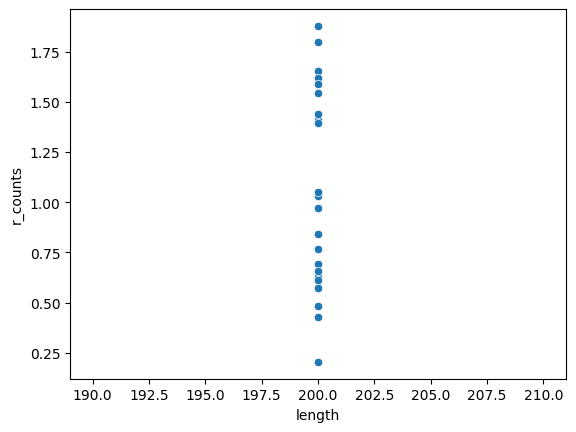

In [55]:
# link between size of amplicon and total read count
sns.scatterplot(data=sanity_amplicon,x='length',y='r_counts')

### GC bias

In [56]:
sanity_amplicon.id = sanity_amplicon.id.apply(str)
sanity_amplicon = sanity_amplicon.set_index('id')

In [57]:
sanity_amplicon = sanity_amplicon.join(normal_cell_expectation[['GC']])
sanity_amplicon

,CHROM,start_pos,end_pos,length,r_counts,GC
id,,,,,,
b'AML_v2_NRAS_115256512',chr1,52,252,200,1.545855,0.507463
b'AML_v2_NRAS_115258635',chr1,1936,2136,200,1.032022,0.542289
b'AML_v2_DNMT3A_25457166',chr2,1589,1789,200,0.841955,0.497512
b'AML_v2_DNMT3A_25458540',chr2,1800,2000,200,1.878478,0.601990
b'AML_v2_DNMT3A_25459813',chr2,2083,2283,200,0.425973,0.482587
b'AML_v2_DNMT3A_25461902',chr2,1975,2175,200,1.798321,0.472637
b'AML_v2_DNMT3A_25463127',chr2,135,335,200,1.408224,0.522388
b'AML_v2_DNMT3A_25463515',chr2,469,669,200,0.692975,0.527363
b'AML_v2_DNMT3A_25464443',chr2,1506,1706,200,0.578499,0.527363


<Axes: xlabel='length', ylabel='GC'>

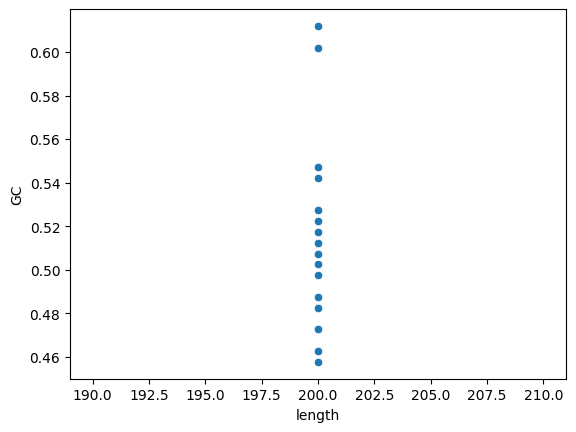

In [58]:
# link between size of amplicon and GC content
sns.scatterplot(data=sanity_amplicon,x='length',y='GC')

<Axes: xlabel='GC', ylabel='r_counts'>

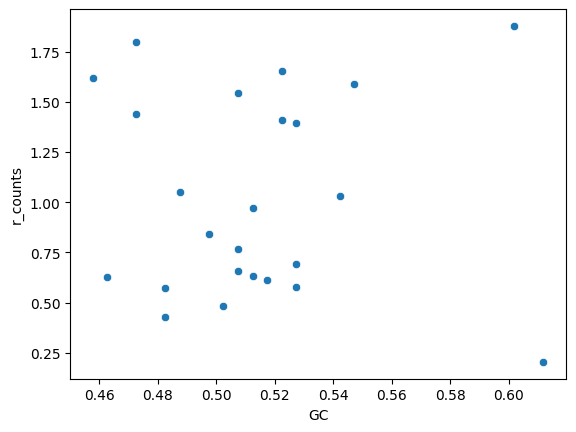

In [59]:
# link between GC content of amplicon and read count
sns.scatterplot(data=sanity_amplicon,x='GC',y='r_counts')

In [ ]:
# GC bias after normalization
#sns.scatterplot(data=sanity_amplicon,x='GC',y='r1_counts')

# Comparison

/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


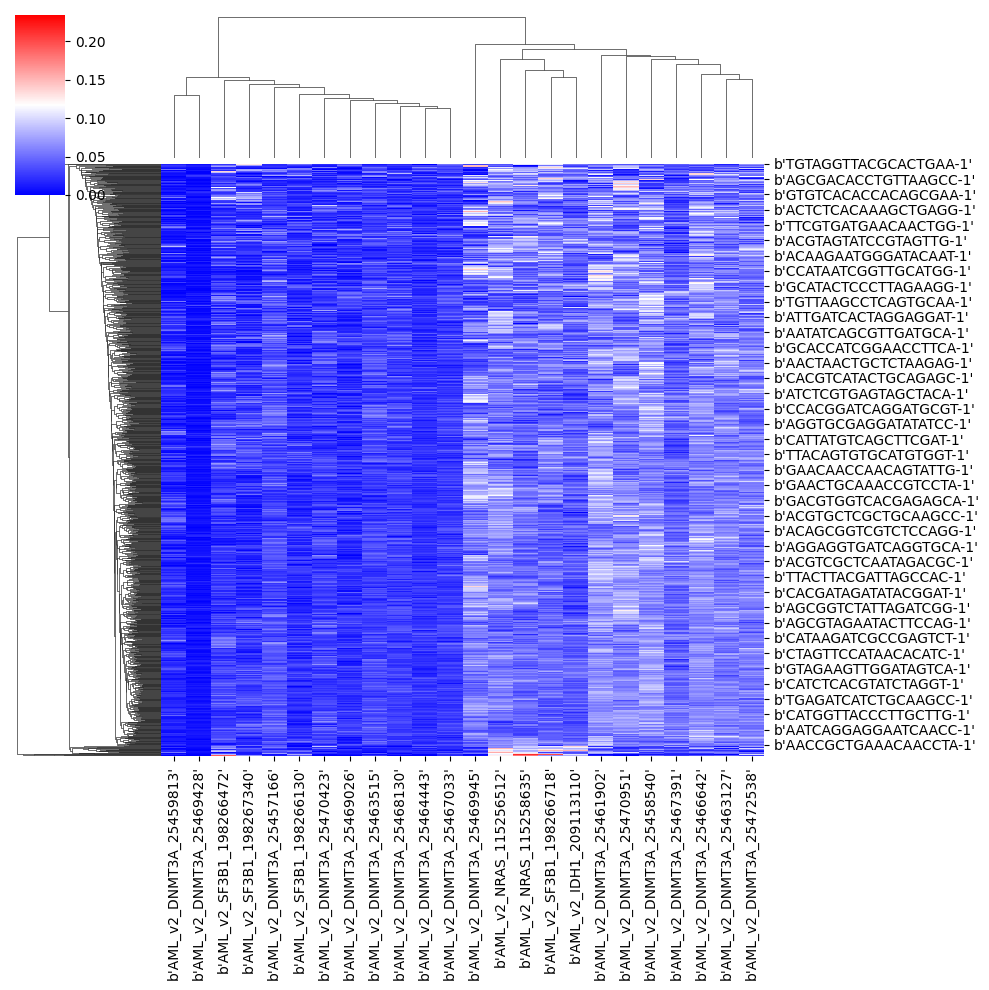

In [60]:
no_norm_cluster = sns.clustermap(small_read_counts.apply(lambda x : x/small_read_counts.sum(axis=1), axis=0),cmap="bwr")
no_norm_cluster

In [33]:
no_norm_cluster.dendrogram_row.reordered_ind
no_norm_cluster.dendrogram_col.reordered_ind

24

/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


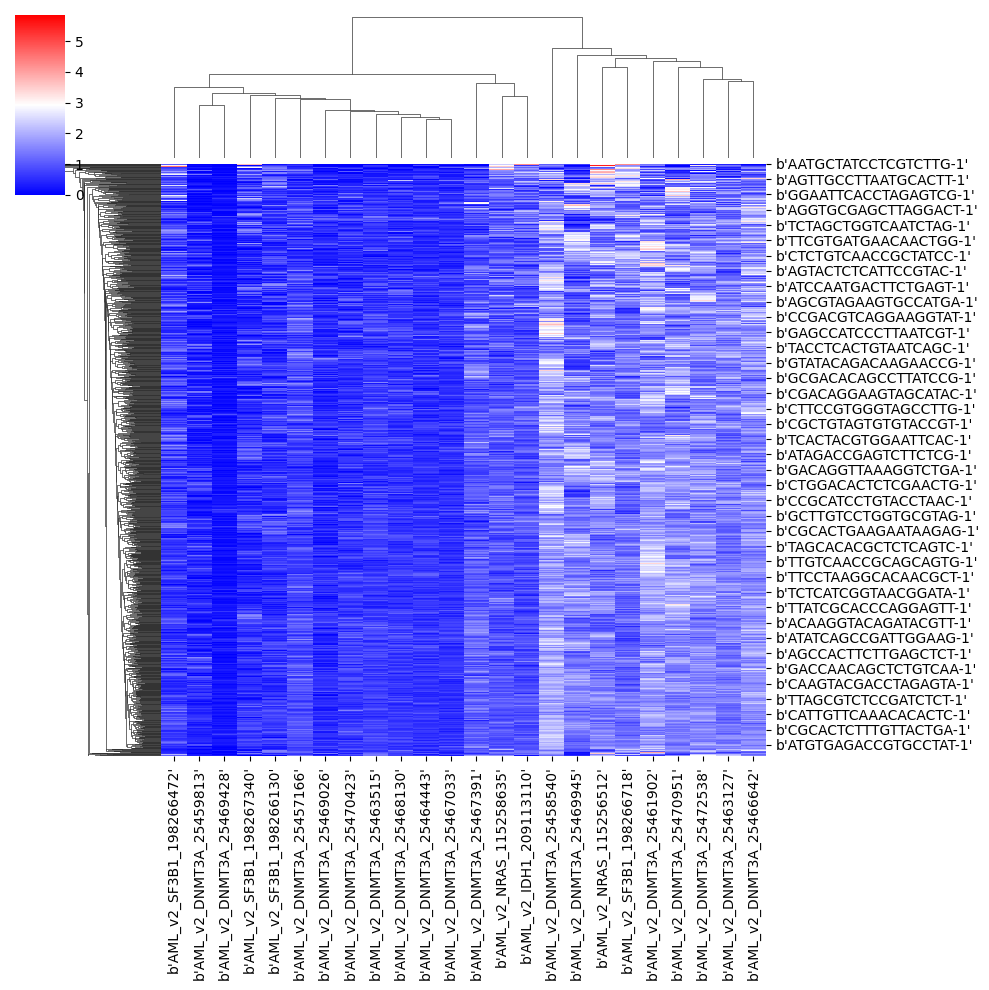

In [61]:
sns.clustermap(norm_read_count.T,cmap="bwr")

In [67]:
norm_read_count_reorder = norm_read_count.T[norm_read_count.T.columns.values[no_norm_cluster.dendrogram_col.reordered_ind]].copy()
norm_read_count_reorder = norm_read_count_reorder.reindex(norm_read_count_reorder.index.values[no_norm_cluster.dendrogram_row.reordered_ind])

<Axes: >

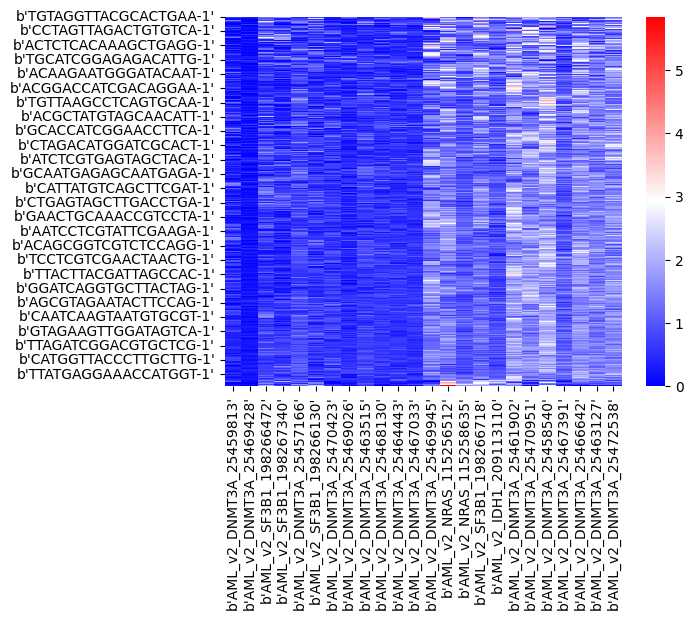

In [69]:
sns.heatmap(norm_read_count_reorder, cmap='bwr')